In [1]:
# Based on Google's Udacity Deep Learning course, Assignments 1-4

%reload_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
import os.path
assert os.path.basename(os.getcwd()) == 'notebooks', os.path.basename(os.getcwd())
code_dir = os.path.join(os.getcwd(), os.pardir, 'code')
if code_dir not in sys.path:
    sys.path.append(code_dir)
    os.environ['PYTHONPATH'] = os.environ.get('PYTHONPATH', '') + os.pathsep + code_dir
model_dir = os.path.join(os.getcwd(), os.pardir, 'models')
data_dir = os.path.join(os.getcwd(), os.pardir, 'data')
    
import keras
%aimport keras_util

Using TensorFlow backend.


In [3]:
from keras.utils import get_file
import string

def fullpath_listdir(dirname):
    return [os.path.join(dirname, fname) for fname in os.listdir(dirname)]    

def get_notmnist_tgz(base, expected_count, expected_classes):
    notmnist_origin = 'https://commondatastorage.googleapis.com/books1000/'
    subdir = 'notmnist'
    target = os.path.join(data_dir, subdir, base)
    if os.path.isdir(target):
        classdirs = fullpath_listdir(target)
        num_class_files = [len(os.listdir(classdir)) for classdir in classdirs]
        all_examples_present = all(num_files >= expected_count for num_files in num_class_files)
        all_classes_present = all(i in os.listdir(target) for i in expected_classes)
        if all_classes_present and all_examples_present:
            print(base, 'already extracted')
            return target
    ext = '.tar.gz'
    get_file(base + ext, notmnist_origin + base + ext, cache_dir=data_dir, cache_subdir=subdir, extract=True)
    return target

train_dir = get_notmnist_tgz('notMNIST_large', 50000, string.ascii_uppercase[:10])
test_dir = get_notmnist_tgz('notMNIST_small', 1800, string.ascii_uppercase[:10])

notMNIST_large already extracted
notMNIST_small already extracted


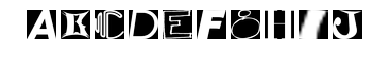

images are 28x28


In [5]:
classdirs = fullpath_listdir(train_dir)
classdirs.sort()
np.random.seed(1234)
selected_images = [np.random.choice(fullpath_listdir(classdir)) for classdir in classdirs]

from matplotlib.image import imread

# https://stackoverflow.com/questions/36006136/
fig = plt.figure()
for i, f in enumerate(selected_images, start=1):
    ax = fig.add_subplot(1, len(selected_images), i)
    plt.imshow(imread(f), cmap='Greys_r')
    plt.axis('off')

plt.show()

imheight, imwidth = imread(selected_images[0]).shape
print('images are {}x{}'.format(imwidth, imheight))

### Raw Data Ingestion

Load all the pictures as greyscale matrices, and deduplicate exact matches

In [6]:
from keras.preprocessing.image import img_to_array, load_img
import multiprocessing
import contextlib
from sklearn.preprocessing import MultiLabelBinarizer
from joblib import Memory

onehot = MultiLabelBinarizer().fit(classes)

def img_from_file(fname):
    im = load_img(fname, grayscale=True, target_size=(imheight, imwidth))
    return img_to_array(im, data_format='channels_last') # TODO: don't make it float yet...

train_classdirs = fullpath_listdir(train_dir)

def no_rows(*shape):
    shape_tup = (0, ) + tuple(shape)
    return np.empty(shape=shape_tup, dtype=np.float32)


def labelled_img(fname):
    try:
        label = os.path.basename(os.path.dirname(fname))
        x = img_from_file(fname).reshape(1, 28, 28)
        y = onehot.transform(label).astype(np.float32)
        return x, y
    except IOError as e:
        print(e)
    return no_rows(28, 28), no_rows(10)

memory = Memory(cachedir=os.path.join(train_dir, os.path.pardir), verbose=1)

@memory.cache
def load_raw(directory):
    all_fnames = [
        f for clsdir in fullpath_listdir(directory)
        if os.path.isdir(clsdir) for f in fullpath_listdir(clsdir)
    ]
    with contextlib.closing(
            multiprocessing.Pool(multiprocessing.cpu_count())) as pool:
        xy = pool.map(labelled_img, all_fnames, chunksize=100)
        return tuple(np.vstack(ls) for ls in zip(*xy))

In [7]:
import contexttimer
from tabulate import tabulate

with contexttimer.Timer() as train_time:
    trainx, trainy = load_raw(train_dir)
    
with contexttimer.Timer() as test_time:
    testx, testy = load_raw(test_dir)

print(tabulate(
    [['train', trainx.shape, trainy.shape, train_time.elapsed],
     ['test', testx.shape, testy.shape, test_time.elapsed]],
    ['data set', 'x {}'.format(trainx.dtype), 'y {}'.format(trainy.dtype), 'load time'],
    tablefmt='grid'))

________________________________________________________________________________
[Memory] Calling __main__--home-mluser-saved-docker-learning-to-deep-learn-notebooks-__ipython-input__.load_raw...
load_raw('/home/mluser/saved-docker/learning-to-deep-learn/notebooks/../data/notmnist/notMNIST_large')
cannot identify image file '/home/mluser/saved-docker/learning-to-deep-learn/notebooks/../data/notmnist/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png'
cannot identify image file '/home/mluser/saved-docker/learning-to-deep-learn/notebooks/../data/notmnist/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png'
cannot identify image file '/home/mluser/saved-docker/learning-to-deep-learn/notebooks/../data/notmnist/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png'
cannot identify image file '/home/mluser/saved-docker/learning-to-deep-learn/notebooks/../data/notmnist/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png'
cannot identify image file '/home/mluser/saved-docker/learning-to-deep-learn/

In [17]:
# Deduplicate exactly-equal images
@memory.cache
def unique_rows(matrix_name):
    nparr = eval(matrix_name)
    assert nparr.ndim > 1
    matrix = nparr.reshape(len(nparr), -1)
    _, ind = np.unique(matrix, axis=0, return_index=True)
    return ind

unique_ind = unique_rows('trainx')
print('dedup reduced training size from {} to {}'.format(len(trainx), len(unique_ind)))
trainx, trainy = trainx[unique_ind], trainy[unique_ind]

________________________________________________________________________________
[Memory] Calling __main__--home-mluser-saved-docker-learning-to-deep-learn-notebooks-__ipython-input__.unique_rows...
unique_rows('trainx')
_____________________________________________________unique_rows - 24.6s, 0.4min
dedup reduced training size from 529114 to 461946


In [83]:
from sklearn.model_selection import train_test_split

train_and_validx, train_and_validy = trainx, trainy
trainx, validx, trainy, validy = train_test_split(trainx, trainy, test_size=0.3, random_state=5678)

((226353, 28, 28), (97009, 28, 28))

### Neural Network Baselines

Use logistic regression and fine-tuned VGG to establish a baseline performance value.

In [84]:
# TODO: logistic, pre-trianed vgg or whatever keras has pre-trianed.
# use multi-gpu setup

# follow tutorial on
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# for fine-tuning
# kerasutil - two-round post-train with validation set helper method

# current best is 97.4%
# http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595

In [33]:

# The entire dataset fits into memory but it'll be good exercise to use
# more convenient tools (which will come in handy for larger datasets)
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2, 
    fill_mode='constant')

(28, 28)

### Use faiss to further slim down very similar images

Close approximate matches aren't useful for training either. Find the top-10 matches for each image, then amongst all top-10 selections find a fuzzy match distance that is acceptable to deduplicate.

In [18]:
train_matrix = trainx.reshape(trainx.shape[0], -1)
num_vecs, vec_dim = train_matrix.shape

In [19]:
import faiss

ngpu = keras_util.ngpu()
# faiss uses swig, which fails unless we hold all these objects
# in lists explicitly
resources = [faiss.StandardGpuResources() for i in range(ngpu)]

index = faiss.index_factory(vec_dim, 'IVF{},Flat'.format(int(np.sqrt(num_vecs) * 10)))
index.nprobe = 10
opts = faiss.GpuMultipleClonerOptions()
index = faiss.index_cpu_to_gpu_multiple_py(resources, index, opts)

In [20]:
with contexttimer.Timer() as t:
    index.train(train_matrix)
    index.add(train_matrix)
print('Trained image similarity index in {:.2f} sec'.format(t.elapsed))

Trained image similarity index in 30.04 sec


In [21]:
k = 10
with contexttimer.Timer() as t:
    distances, indices = index.search(train_matrix, k)
print('Found top-{} similarity matches for all images in {:.2f} sec'.format(k, t.elapsed))

Found top-10 similarity matches for all images in 9.15 sec


In [12]:
# Free GPU memory
del index, resources, opts

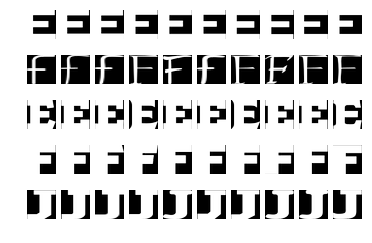

In [22]:
fig = plt.figure()
np.random.seed(1234)
nsamples = 5
selected_images = np.random.choice(np.arange(len(indices)), nsamples)
image_indices = np.concatenate([indices[i] for i in selected_images])
for i, image_index in enumerate(image_indices, start=1):
    ax = fig.add_subplot(nsamples, k, i)
    plt.imshow(trainx[image_index], cmap='Greys_r')
    plt.axis('off')

plt.show()

The above shows that L2 metric on the raw image data might not be enough since clearly different fonts for the same letter are viewed as neighbors, even though we'd like to match only with the same font that's been repeated between two images (but isn't an exact duplicate, since those were already filtered out).